# Part 2: Advanced Configuration

## Load MNIST dataset from tf.keras

In [ ]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

### Let's print some information about the dataset
Print the the dataset shape

In [ ]:
print(x_train.shape, x_test.shape,y_train.shape, y_test.shape)

## Load the model
Load the model trained in 'part1_tutorial'. **Make sure you've run through that walkthrough first!**

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_mnist_cnn/KERAS_check_best_model.h5')
y_keras = model.predict(x_test)

## Make an hls4ml config & model
This time, we'll create a config with finer granularity. When we print the config dictionary, you'll notice that an entry is created for each named Layer of the model. See for the first layer, for example:
```
HLSConfig:    
    LayerName:
        conv2d:
            Precision:
                weight: ap_fixed<16,6>
                bias:   ap_fixed<16,6>
            ReuseFactor: 1
```
Taken 'out of the box' this config will set all the parameters to the same settings as in part 1, but we can use it as a template to start modifying things. 

In [ ]:
import hls4ml
from hls4ml.converters.keras_to_hls import keras_to_hls
import yaml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['Backend']='VivadoAccelerator'
config['OutputDir'] = 'mnist-hls-test'
config['ProjectName'] = 'myproject_mnist_cnn'
config['XilinxPart']= 'xczu7ev-ffvc1156-2-e'
config['Board'] = 'zcu104'
config['ClockPeriod'] = 5
config['IOType'] = 'io_stream'

config['LayerName']['input_1']['Trace'] = True
config['LayerName']['conv2d']['Trace'] = True
config['LayerName']['conv2d_relu']['Trace'] = True
config['LayerName']['max_pooling2d']['Trace'] = True
config['LayerName']['conv2d_1']['Trace'] = True
config['LayerName']['conv2d_1_relu']['Trace'] = True
config['LayerName']['max_pooling2d_1']['Trace'] = True
config['LayerName']['dense']['Trace'] = True
config['LayerName']['dense_linear']['Trace'] = True
config['LayerName']['activation']['Trace'] = True



config['HLSConfig']={}
config['HLSConfig']['Model']={}
config['HLSConfig']['Model']=config['Model']
config['HLSConfig']['LayerName']=config['LayerName']
del config['Model']
del config['LayerName']
config['AcceleratorConfig']={}
config['AcceleratorConfig']['Interface'] = 'axi_stream'
config['AcceleratorConfig']['Driver'] = 'python'
config['AcceleratorConfig']['Precision']={}
config['AcceleratorConfig']['Precision']['Input']= 'float'
config['AcceleratorConfig']['Precision']['Output']= 'float'
config['KerasModel'] = model



print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")

## Profiling
As you can see, we can choose the precision of _everything_ in our Neural Network. This is a powerful way to tune the performance, but it's also complicated. The tools in `hls4ml.model.profiling` can help you choose the right precision for your model. (That said, training your model with quantization built in can get around this problem, and that is introduced in Part 4. So, don't go too far down the rabbit hole of tuning your data types without first trying out quantization aware training with QKeras.)

The first thing to try is to numerically profile your model. This method plots the distribution of the weights (and biases) as a box and whisker plot. The grey boxes show the values which can be represented with the data types used in the `hls_model`. Generally, you need the box to overlap completely with the whisker 'to the right' (large values) otherwise you'll get saturation & wrap-around issues. It can be okay for the box not to overlap completely 'to the left' (small values), but finding how small you can go is a matter of trial-and-error.

Providing data, in this case just using the first 1000 examples for speed, will show the same distributions captured at the output of each layer.

In [ ]:
from hls4ml.model.profiling import numerical
hls_model = keras_to_hls(config)
numerical(model=model, hls_model=hls_model, X=x_test[:1000])

## Customize
Let's just try setting the precision of the first layer weights to something more narrow than 16 bits. Using fewer bits can save resources in the FPGA. After inspecting the profiling plot above, let's try 8 bits with 1 integer bit.

Then create a new `HLSModel`, and display the profiling with the new config. This time, just display the weight profile by not providing any data '`X`'. Then create the `HLSModel` and display the architecture. Notice the box around the weights of the first layer reflects the different precision.

In [ ]:
config['HLSConfig']['LayerName']['conv2d']['Precision']['weight'] = 'ap_fixed<8,2>'
config['HLSConfig']['LayerName']['conv2d']['Precision']['bias'] = 'ap_fixed<8,2>'
config['OutputDir']='mnist-hls-test2'
config['ProjectName'] = 'myproject_mnist_cnn2'
hls_model = keras_to_hls(config)
numerical(model=model, hls_model=hls_model, X=x_test[:1000])
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Trace
When we start using customised precision throughout the model, it can be useful to collect the output from each layer to find out when things have gone wrong. We enable this trace collection by setting `Trace = True` for each layer whose output we want to collect.

In [ ]:
for layer in config['HLSConfig']['LayerName'].keys():
    config['HLSConfig']['LayerName'][layer]['Trace'] = True
hls_model = keras_to_hls(config)

## Compile, trace, predict
Now we need to check that this model performance is still good after reducing the precision. We compile the `hls_model`, and now use the `hls_model.trace` method to collect the model output, and also the output for all the layers we enabled tracing for. This returns a dictionary with keys corresponding to the layer names of the model. Stored at that key is the array of values output by that layer, sampled from the provided data.
A helper function `get_ymodel_keras` will return the same dictionary for the Keras model.

We'll just run the `trace` for the first 1000 examples, since it takes a bit longer and uses more memory than just running `predict`. 

In [ ]:
hls_model.compile()
hls4ml_pred, hls4ml_trace = hls_model.trace(x_test[:1000])
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, x_test[:1000])
y_hls = hls_model.predict(x_test)

## Inspect
Now we can print out, make plots, or do any other more detailed analysis on the output of each layer to make sure we haven't made the performance worse. And if we have, we can quickly find out where. Let's just print the output of the first layer, for the first sample, for both the Keras and hls4ml models.

In [ ]:
print("Keras layer 'conv2d', first sample:")
print(keras_trace['conv2d'][0])
print("hls4ml layer 'conv2d', first sample:")
print(hls4ml_trace['conv2d'][0])

## Compare
Let's see if we lost performance by using 8 bits for the weights of the first layer by inspecting the accuracy and ROC curve.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

mnist_classes=['0','1','2','3','4','5','6','7','8','9']

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, mnist_classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls, mnist_classes, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

## ReuseFactor
Now let's look at the other configuration parameter: `ReuseFactor`.
Recall that `ReuseFactor` is our mechanism for tuning the parallelism:


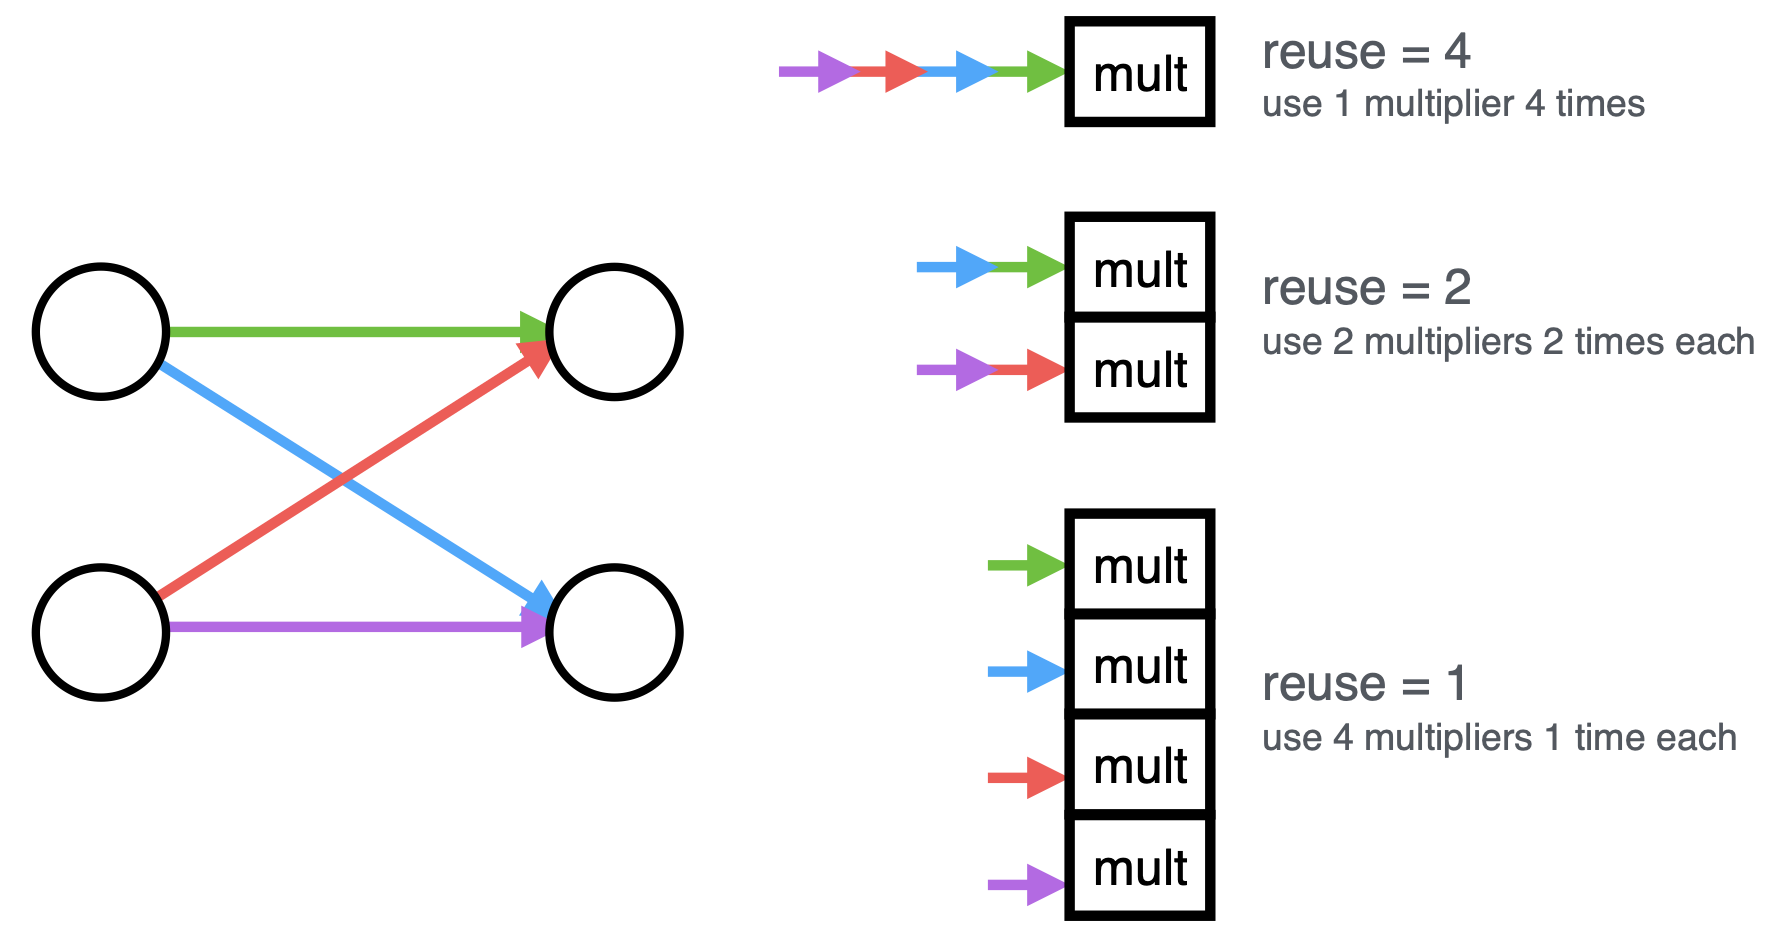

In [ ]:

config['OutputDir']='mnist-hls-test2'
config['ProjectName'] = 'mnist-hls-test2'
config['HLSConfig']['LayerName']['conv2d']['ReuseFactor'] = 8
config['HLSConfig']['LayerName']['conv2d_1']['ReuseFactor'] = 8
config['HLSConfig']['LayerName']['dense']['ReuseFactor'] = 8
hls_model = keras_to_hls(config)



print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")


hls_model.compile()
y_hls = hls_model.predict(x_test)
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, mnist_classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls, mnist_classes, linestyle='--')

Now build the model

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f mnist-hls-test2/vivado_hls.log`

In [ ]:
os.environ['PATH'] = '/workspace/home/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
hls_model.build(csim=False,synth=True,export=True)

And now print the report, compare this to the report from Exercise 1

In [ ]:
hls4ml.report.read_vivado_report(config['OutputDir'])

In [ ]:
hls4ml.report.read_vivado_report('mnist-hls-test')